In [1]:
import sys
sys.path.insert(0, "/Users/rstiskalek/Projects/candel")

import numpyro
numpyro.set_host_device_count(10)

import numpy as np
import matplotlib.pyplot as plt
import scienceplots

from scipy.stats import norm
import candel

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [6]:
config_path = "/Users/rstiskalek/Projects/CANDEL/scripts/runs/config_shoes.toml"
data = candel.pvdata.load_SH0ES_from_config(config_path, )

model = candel.model.SH0ESModel(config_path, data)


print("Priors are:")
print(model.prior_dist_name)

2025-08-20 14:32:46 warning: zero width found in the priors. Setting it to 1e-5.
2025-08-20 14:32:46 indices of zero width: [44]
2025-08-20 14:32:46 found zero-width prior at index 44. Setting it to 0.
2025-08-20 14:32:47 normalizing the Manticore LOS density.
2025-08-20 14:32:48 replacing prior of `A_covmat` with a delta function.
2025-08-20 14:32:48 replacing prior of `beta` with a delta function.
2025-08-20 14:32:48 loading host galaxy LOS interpolators.
2025-08-20 14:32:48 Popped the following keys with `None` values from data: czcmb_SN_HF, e_czcmb_SN_HF, RA_SN_HF, dec_SN_HF
2025-08-20 14:32:48 Converting host RA/dec to Cartesian coordinates.
2025-08-20 14:32:48 set the following attributes: mag_cepheid, logP, OH, C_Cepheid, L_Cepheid, L_Cepheid_host_dist, Cepheids_only, num_cepheids, num_hosts, Y_SN_Cepheid, C_SN_Cepheid, L_SN_Cepheid, L_SN_Cepheid_dist, mag_SN_unique_Cepheid_host, C_SN_unique_Cepheid_host, std_mag_SN_unique_Cepheid_host, L_SN_unique_Cepheid_host, L_SN_unique_Ceph

In [7]:
samples = candel.run_SH0ES_inference(model, )

2025-08-20 14:32:48 running inference on devices: cpu(cpu), cpu(cpu), cpu(cpu), cpu(cpu), cpu(cpu), cpu(cpu), cpu(cpu), cpu(cpu), cpu(cpu), cpu(cpu)
2025-08-20 14:32:48 using NumPyro platform: CPU


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]


                 mean       std    median      5.0%     95.0%     n_eff     r_hat
         H0     71.79      1.06     71.76     70.05     73.52   1146.75      1.00
        M_B    -19.29      0.03    -19.29    -19.34    -19.24   1101.91      1.00
        M_W     -5.92      0.02     -5.92     -5.95     -5.89   1475.23      1.00
        Z_W     -0.16      0.05     -0.16     -0.24     -0.07   4370.41      1.00
        b_W     -3.29      0.01     -3.29     -3.32     -3.27   3657.67      1.00
        dZP     -0.00      0.04     -0.00     -0.06      0.05   2295.72      1.00
     mu_LMC     18.48      0.03     18.48     18.44     18.52   4524.18      1.00
     mu_M31     24.40      0.07     24.40     24.29     24.51   4618.02      1.00
   mu_N4258     29.41      0.02     29.41     29.37     29.45   2493.55      1.00
 mu_host[0]     29.19      0.04     29.19     29.12     29.26   2807.98      1.00
 mu_host[1]     32.96      0.08     32.96     32.82     33.10   4173.95      1.00
 mu_host[2]    

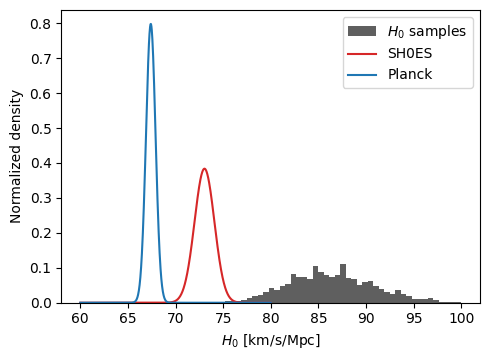

In [25]:
fig, ax = plt.subplots(figsize=(5, 3.7),)

# Histogram of H0 samples (normalize to max height = 1)
counts, bins, _ = ax.hist(
    samples["H0"], bins="auto", density=True, alpha=0.9, color="0.3",
    label=r"$H_0$ samples"
)
max_density = counts.max()

# Define a range for the Gaussians
H0_vals = np.linspace(60, 80, 1000)

# SH0ES (e.g. Riess+2021), normalized to match
H0_SH0ES = 73.04
H0_SH0ES_err = 1.04
shoes_pdf = norm.pdf(H0_vals, loc=H0_SH0ES, scale=H0_SH0ES_err)
# shoes_pdf /= shoes_pdf.max()  # normalize peak to 1
# shoes_pdf *= max_density      # scale to match sample histogram
ax.plot(H0_vals, shoes_pdf, color="tab:red", label="SH0ES")

# Planck (e.g. Planck 2018), normalized to match
H0_Planck = 67.4
H0_Planck_err = 0.5
planck_pdf = norm.pdf(H0_vals, loc=H0_Planck, scale=H0_Planck_err)
# planck_pdf /= planck_pdf.max()
# planck_pdf *= max_density
ax.plot(H0_vals, planck_pdf, color="tab:blue", label="Planck")

ax.set_xlabel(r"$H_0~[\mathrm{km/s/Mpc}]$")
ax.set_ylabel("Normalized density")
ax.legend()

plt.tight_layout()
fig.savefig("/Users/rstiskalek/Downloads/H0_samples.png", bbox_inches="tight", dpi=450)
plt.show()

In [14]:
from scipy.stats import norm
import posterior_agreement


H0 = norm(69.1, 1.2).rvs(50_000)
# H0_test = norm(67.4, 0.5).rvs(50000)
H0_test = norm(73.04, 1.04).rvs(50000)



chains = (H0, H0_test)
agreement_1d = posterior_agreement.compute_agreement(chains)

print("p-value %.3f, corresponding to %.4f sigmas"%(agreement_1d.PTE, agreement_1d.sigma))

p-value 0.011, corresponding to 2.5368 sigmas


In [2]:


values = np.array([70.9, 72, 69.3])
errors = np.array([1.3, 1.3, 1.4])


samples = []
for mu, err in zip(values, errors):
    samples.append(norm(mu, err).rvs(50000))


samples = np.array(samples).flatten()

In [3]:
samples.mean(), samples.std()

(70.72935530213319, 1.7358712364314264)

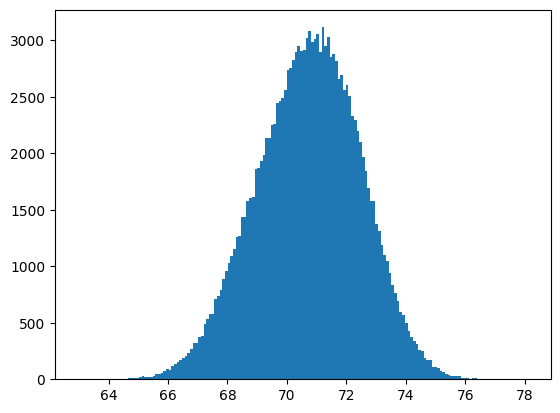

In [4]:
plt.figure()
plt.hist(samples, bins="auto")

plt.show()